In [1]:
# upload data and import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.feature_selection import RFE, RFECV, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV, LinearRegression, Ridge 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, roc_curve, auc,roc_auc_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

df1 = pd.read_excel (r'/Users/james1/Documents/Documents/Data Science minor/donor data.xlsx', header = 1) 
df2 = pd.read_excel(r'/Users/james1/Documents/Documents/Data Science minor/kwb-2019.xls')

df1.info(verbose = True)
df1.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23128 entries, 0 to 23127
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          23128 non-null  int64 
 1   DonorCharacteristics        23128 non-null  object
 2   Regio                       23128 non-null  object
 3   Periods                     23128 non-null  object
 4   DonorregisterFixedChoice_1  23128 non-null  object
 5   DonorregisterFixedChoice_2  23128 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.1+ MB


,ID,DonorCharacteristics,Regio,Periods,DonorregisterFixedChoice_1,DonorregisterFixedChoice_2
0,0,T001421,NL01,2014JJ00,14591,100
1,1,T001421,NL01,2015JJ00,14685.1,100
2,2,T001421,NL01,2016JJ00,14782.6,100
3,3,T001421,NL01,2017JJ00,14895.2,100
4,4,T001421,NL01,2018JJ00,15005.8,100


# Preprocessing

## Dataframe 1 - donor registration

In [2]:
# preprocessing of donor dataset (df1)

# get rid of years that aren't 2019 in donor dataset

df1 = df1[df1.Periods == '2019JJ00']

# get rid of regions outside our scope (we are interested in 'GM' regions)

df1 = df1[df1['Regio'].str.contains("GM")==True]

# get rid of rows that have data for total registered and not registered, rows with data for amount not reigstered, rows with data for those who are regsitered by someone else and rows with those who registered and gave permission- we are only interested in seeing the proportion of people did not give (so ie also that give permission to donate organs) amongst those who registered, not the total number of people in region

df1 = df1[(df1.DonorCharacteristics == 'A045380') | (df1.DonorCharacteristics == 'A045383')]

# convert values in 'DonorregisterFixedChoice_1' from string to float

df1["DonorregisterFixedChoice_1"] = pd.to_numeric(df1["DonorregisterFixedChoice_1"], errors = 'coerce', downcast="float")

# drop missing values

df1 = df1.dropna()

In [3]:
# check data to make sure pre-processing was successful

df1.info() # 22,416 values dropped
print(df1.DonorCharacteristics.unique()) 
print(df1.Regio.unique())
print(df1.Periods.unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 710 entries, 3295 to 14446
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          710 non-null    int64  
 1   DonorCharacteristics        710 non-null    object 
 2   Regio                       710 non-null    object 
 3   Periods                     710 non-null    object 
 4   DonorregisterFixedChoice_1  710 non-null    float32
 5   DonorregisterFixedChoice_2  710 non-null    object 
dtypes: float32(1), int64(1), object(4)
memory usage: 36.1+ KB
['A045380' 'A045383']
['GM1680' 'GM0358' 'GM0197' 'GM0059' 'GM0482' 'GM0613' 'GM0361' 'GM0141'
 'GM0034' 'GM0484' 'GM1723' 'GM1959' 'GM0060' 'GM0307' 'GM0362' 'GM0363'
 'GM0200' 'GM0003' 'GM0202' 'GM0106' 'GM0743' 'GM0744' 'GM0308' 'GM0489'
 'GM0203' 'GM0888' 'GM1954' 'GM0370' 'GM0889' 'GM1945' 'GM1724' 'GM0893'
 'GM0373' 'GM0748' 'GM1859' 'GM1721' 'GM0753' 'GM0209' 'GM

In [4]:
# in order to create column with percentage of those who registered that did not donate, it is easiest to seperate the data into two dataframes - splitting at point where data goes from total registered to no permission given - drop the unecessary columns and then rejoin so that final dataframe has total registered and amount not giving permission in seperate columns

df1_a = df1.iloc[:355,:] # split dataframe into two

df1_b = df1.iloc[355:,:]

df1_b = df1_b.drop(columns = ['ID', 'DonorCharacteristics','Periods','DonorregisterFixedChoice_2']) # get rid of unnecessary columns - we just want data of people who did not give permission

df1_b = df1_b.rename(columns = {'DonorregisterFixedChoice_1':'No permission'}) # rename column for easier comprehension

df1 = pd.merge(df1_a, df1_b, on = "Regio") # merge dataframes so that new df1 has only one row per region and column with both number people who registered and people who did not give permission

df1 = df1.drop(columns = ['DonorregisterFixedChoice_2', 'DonorCharacteristics']) # get rid of unnecessary column

df1 = df1.rename(columns = {'DonorregisterFixedChoice_1':'Total registered','Regio':'Region'}) # rename columns for easier comprehension


In [5]:
# check preprocessing thus far

df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 0 to 354
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                355 non-null    int64  
 1   Region            355 non-null    object 
 2   Periods           355 non-null    object 
 3   Total registered  355 non-null    float32
 4   No permission     355 non-null    float32
dtypes: float32(2), int64(1), object(2)
memory usage: 13.9+ KB


,ID,Region,Periods,Total registered,No permission
0,3295,GM1680,2019JJ00,10.5,2.7
1,3302,GM0358,2019JJ00,11.2,3.3
2,3309,GM0197,2019JJ00,10.8,2.6
3,3316,GM0059,2019JJ00,8.7,3.1
4,3323,GM0482,2019JJ00,6.6,2.9


In [6]:
# divide number of people who gave permission by total number registered and minus this from 100 to find number of people who gave permission 

new_column = []
for i in range(len(df1)):
    result = 100 - ((df1['No permission'].iloc[i] / df1['Total registered'].iloc[i])*100)
    new_column.append(result)

        
df1['Permission (%) '] = new_column

# get rid of columns so that just region and percentage who agreed to donate

df1 = df1.drop(columns = ['ID', 'Periods','Total registered','No permission']) 


df1.head()

,Region,Permission (%)
0,GM1680,74.285713
1,GM0358,70.535713
2,GM0197,75.925927
3,GM0059,64.367816
4,GM0482,56.060603


## Dataframe 2 - demographic indicators

In [7]:
df2 = df2[df2['gwb_code_10'].str.contains("GM")==True] # delete non - GM level regions
df2 = df2.rename(columns = {'gwb_code_10':'Region'}) # rename columns
df2 = pd.merge(df2, df1, on = "Region") # merge two datasets
df2 = df2.drop(df2.columns[[6,65,66,67,68,69,70,71,72,73,74,75,80,81,82,-4,-5]], axis = 1) # drop columns that are mostly missing values
df2 =df2.drop(columns = [ 'regio','Region','gwb_code_8','gm_naam','recs', 'gwb_code']) # drop uninterestung columns

# replace ',' with '.' to allow parsing 

df2['g_hhgro']= df2["g_hhgro"].str.replace(",",".")
df2['g_pau_hh']= df2["g_pau_hh"].str.replace(",",".")
df2['g_afs_hp']= df2["g_afs_hp"].str.replace(",",".")
df2['g_afs_gs']= df2["g_afs_gs"].str.replace(",",".")
df2['g_afs_kv']= df2["g_afs_kv"].str.replace(",",".")
df2['g_afs_sc']= df2["g_afs_sc"].str.replace(",",".")
df2['g_3km_sc']= df2["g_3km_sc"].str.replace(",",".")

for column in df2.columns:
    df2[column] = pd.to_numeric(df2[column], downcast = 'float', errors = 'coerce')
    
# impute remaining missing values with mean
  
df2 = df2.fillna(df2.mean())

# check to see dataset is how we want

df2.head(20)

,a_inw,a_man,a_vrouw,a_00_14,a_15_24,a_25_44,a_45_64,a_65_oo,a_ongeh,a_gehuwd,...,g_afs_gs,g_afs_kv,g_afs_sc,g_3km_sc,a_opp_ha,a_lan_ha,a_wat_ha,ste_mvs,ste_oad,Permission (%)
0,11721.0,5720.0,6001.0,1718.0,1238.0,2376.0,3491.0,2898.0,4981.0,4874.0,...,0.9,0.9,0.9,6.4,2458.0,2378.0,80.0,3.0,1067.0,61.363636
1,24716.0,12408.0,12308.0,3498.0,2625.0,4856.0,7552.0,6185.0,10364.0,10501.0,...,1.3,0.9,0.9,6.2,22750.0,13307.0,9443.0,4.0,673.0,61.363636
2,231299.0,114937.0,116362.0,28822.0,50342.0,67886.0,50900.0,33349.0,150951.0,55871.0,...,0.7,0.5,0.7,9.9,19796.0,18560.0,1236.0,1.0,3219.0,75.196411
3,9614.0,4881.0,4733.0,1447.0,1052.0,1893.0,3099.0,2123.0,4187.0,4212.0,...,2.5,1.4,1.4,2.0,11199.0,11104.0,95.0,5.0,213.0,69.444443
4,207904.0,103082.0,104822.0,39067.0,26989.0,57771.0,60643.0,23434.0,108536.0,74912.0,...,0.8,0.5,0.6,14.7,24877.0,12919.0,11958.0,2.0,1601.0,61.380325
5,31789.0,15730.0,16059.0,4531.0,3488.0,6326.0,9514.0,7930.0,12890.0,13863.0,...,1.2,0.9,0.9,5.8,11994.0,11764.0,230.0,4.0,837.0,61.682243
6,27491.0,13685.0,13806.0,4128.0,3045.0,5769.0,8376.0,6173.0,11687.0,11551.0,...,1.2,0.8,0.8,5.5,7868.0,7600.0,268.0,3.0,1001.0,62.626259
7,22309.0,11392.0,10917.0,3983.0,3094.0,5372.0,7006.0,2854.0,10302.0,9618.0,...,1.4,1.4,1.4,8.1,26886.0,24723.0,2163.0,4.0,806.0,72.941177
8,27852.0,14167.0,13685.0,4936.0,3360.0,6190.0,7908.0,5458.0,12607.0,11868.0,...,1.6,0.8,0.7,3.5,10398.0,10223.0,175.0,5.0,427.0,64.367813
9,3673.0,1819.0,1854.0,585.0,381.0,848.0,1031.0,828.0,1677.0,1568.0,...,0.5,1.1,0.8,1.4,26850.0,5911.0,20939.0,5.0,253.0,75.000000


# Models

## Regression

Text(0.5, 1.0, 'Correlation Matrix')

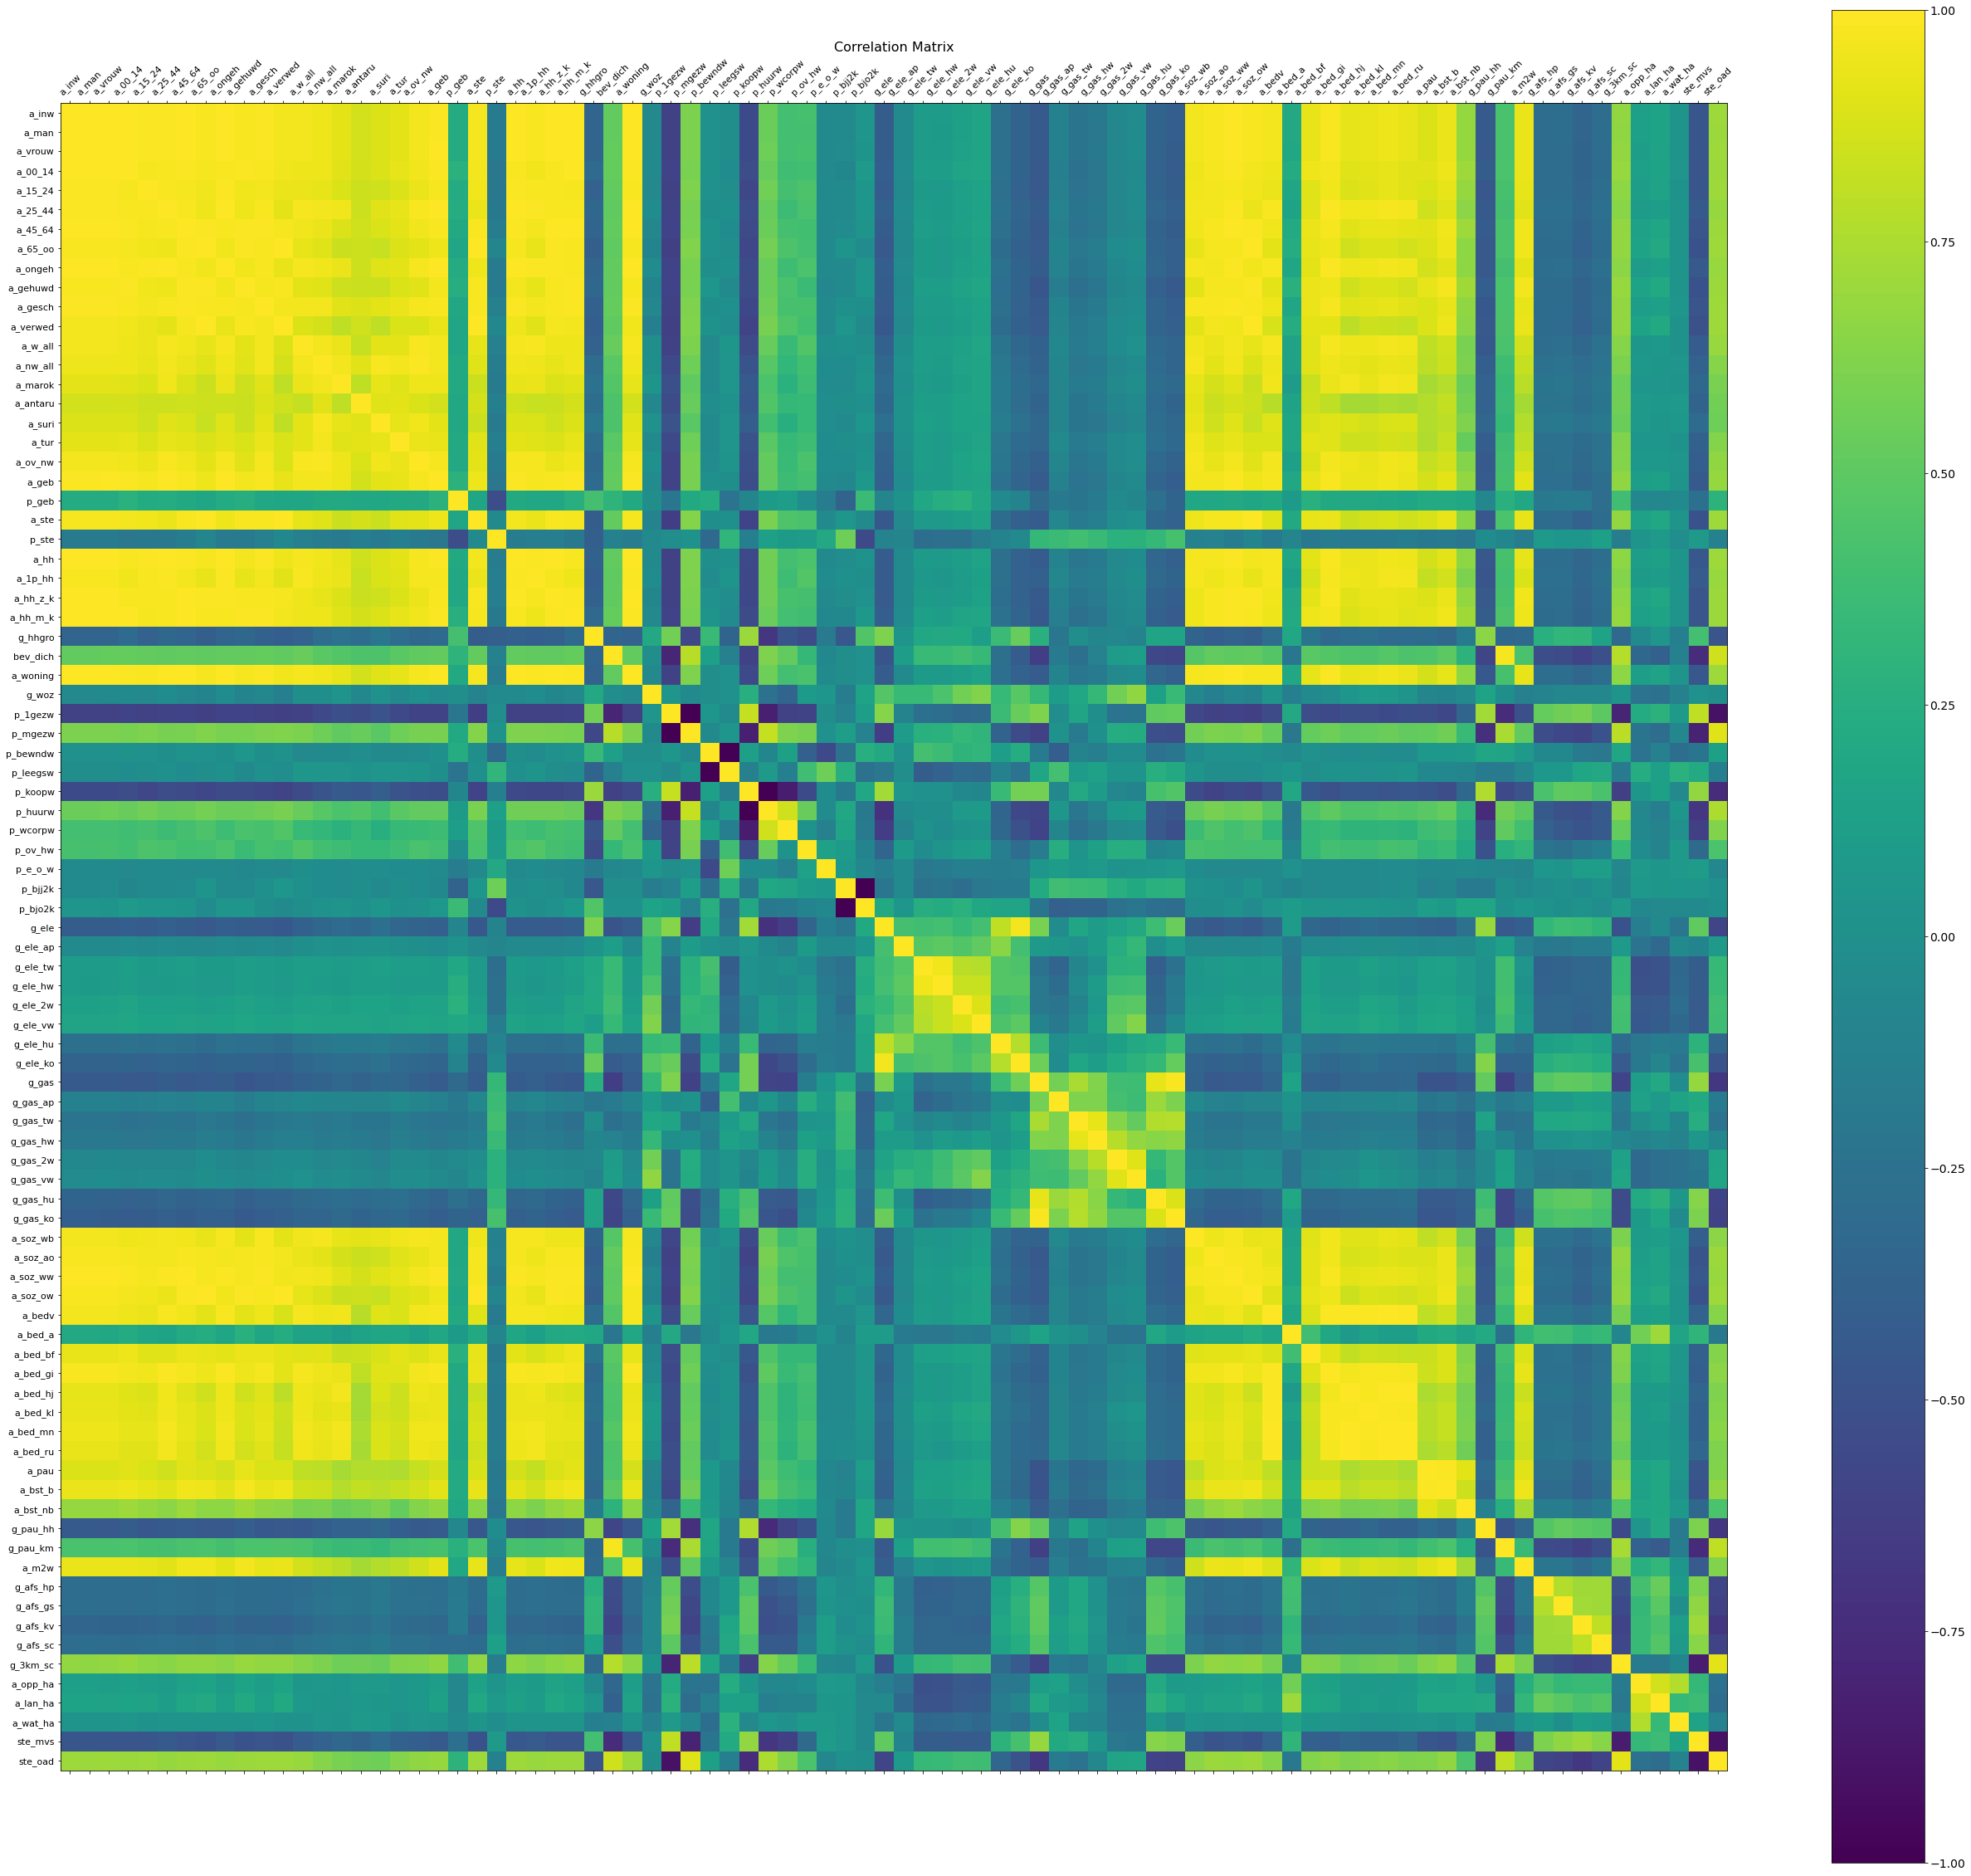

In [8]:
# Make test and train

X = df2.iloc[:,:-1]
y = df2.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)

# inspect multicollinearity

f = plt.figure(figsize=(45, 40))
plt.matshow(X.corr(), fignum=f.number)
plt.xticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=11, rotation=45)
plt.yticks(range(X.select_dtypes(['number']).shape[1]), X.select_dtypes(['number']).columns, fontsize=11)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

Evidence of high multicollinearity among variables. Therefore use Ridge regression

In [9]:
# Ridge with Standard scaler

pipeline_Ridge = Pipeline([('scaler', StandardScaler()),('Ridge', Ridge())])
paramaters_Ridge_grid = {'Ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_ss = GridSearchCV(pipeline_Ridge, param_grid = paramaters_Ridge_grid, cv=5)
grid_ss.fit(X_train, y_train)
print("Training set score: {:.2f}".format(grid_ss.score(X_train, y_train))) 
print("Test set score: {:.2f}".format(grid_ss.score(X_test, y_test)))
print("Optimal alpha = {}".format(grid_ss.best_params_))

Training set score: 0.50
Test set score: 0.46
Optimal alpha = {'Ridge__alpha': 100}


/Users/james1/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.47424e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/james1/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.22358e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/james1/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.77608e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/james1/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.13101e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [10]:
# Ridge with MinMax scaler

pipeline_Ridge = Pipeline([('scaler', MinMaxScaler()),('Ridge', Ridge())])
paramaters_Ridge_grid = {'Ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_mm = GridSearchCV(pipeline_Ridge, param_grid = paramaters_Ridge_grid, cv=5)
grid_mm.fit(X_train, y_train)
print("Training set score: {:.2f}".format(grid_mm.score(X_train, y_train))) 
print("Test set score: {:.2f}".format(grid_mm.score(X_test, y_test)))
print("Optimal alpha = {}".format(grid_mm.best_params_))

Training set score: 0.54
Test set score: 0.49
Optimal alpha = {'Ridge__alpha': 1}


In [11]:
# Feature importance 

reg = grid_mm.best_estimator_.named_steps['Ridge']
importance = reg.coef_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.73958
Feature: 1, Score: 0.79697
Feature: 2, Score: 0.68319
Feature: 3, Score: -0.49335
Feature: 4, Score: 2.74783
Feature: 5, Score: 1.18484
Feature: 6, Score: 0.05489
Feature: 7, Score: 0.20309
Feature: 8, Score: 1.79083
Feature: 9, Score: -1.49577
Feature: 10, Score: -0.47213
Feature: 11, Score: -0.25650
Feature: 12, Score: 0.05174
Feature: 13, Score: -1.78493
Feature: 14, Score: -0.87037
Feature: 15, Score: -2.69414
Feature: 16, Score: -5.09538
Feature: 17, Score: -0.10365
Feature: 18, Score: -0.73091
Feature: 19, Score: -0.02444
Feature: 20, Score: -10.52855
Feature: 21, Score: 0.52631
Feature: 22, Score: -7.86406
Feature: 23, Score: 1.50105
Feature: 24, Score: 2.46148
Feature: 25, Score: 1.26482
Feature: 26, Score: -0.46010
Feature: 27, Score: -13.95006
Feature: 28, Score: -1.83899
Feature: 29, Score: 0.84899
Feature: 30, Score: 8.16504
Feature: 31, Score: 0.84936
Feature: 32, Score: -0.84939
Feature: 33, Score: 2.71912
Feature: 34, Score: -2.71911
Feature: 3

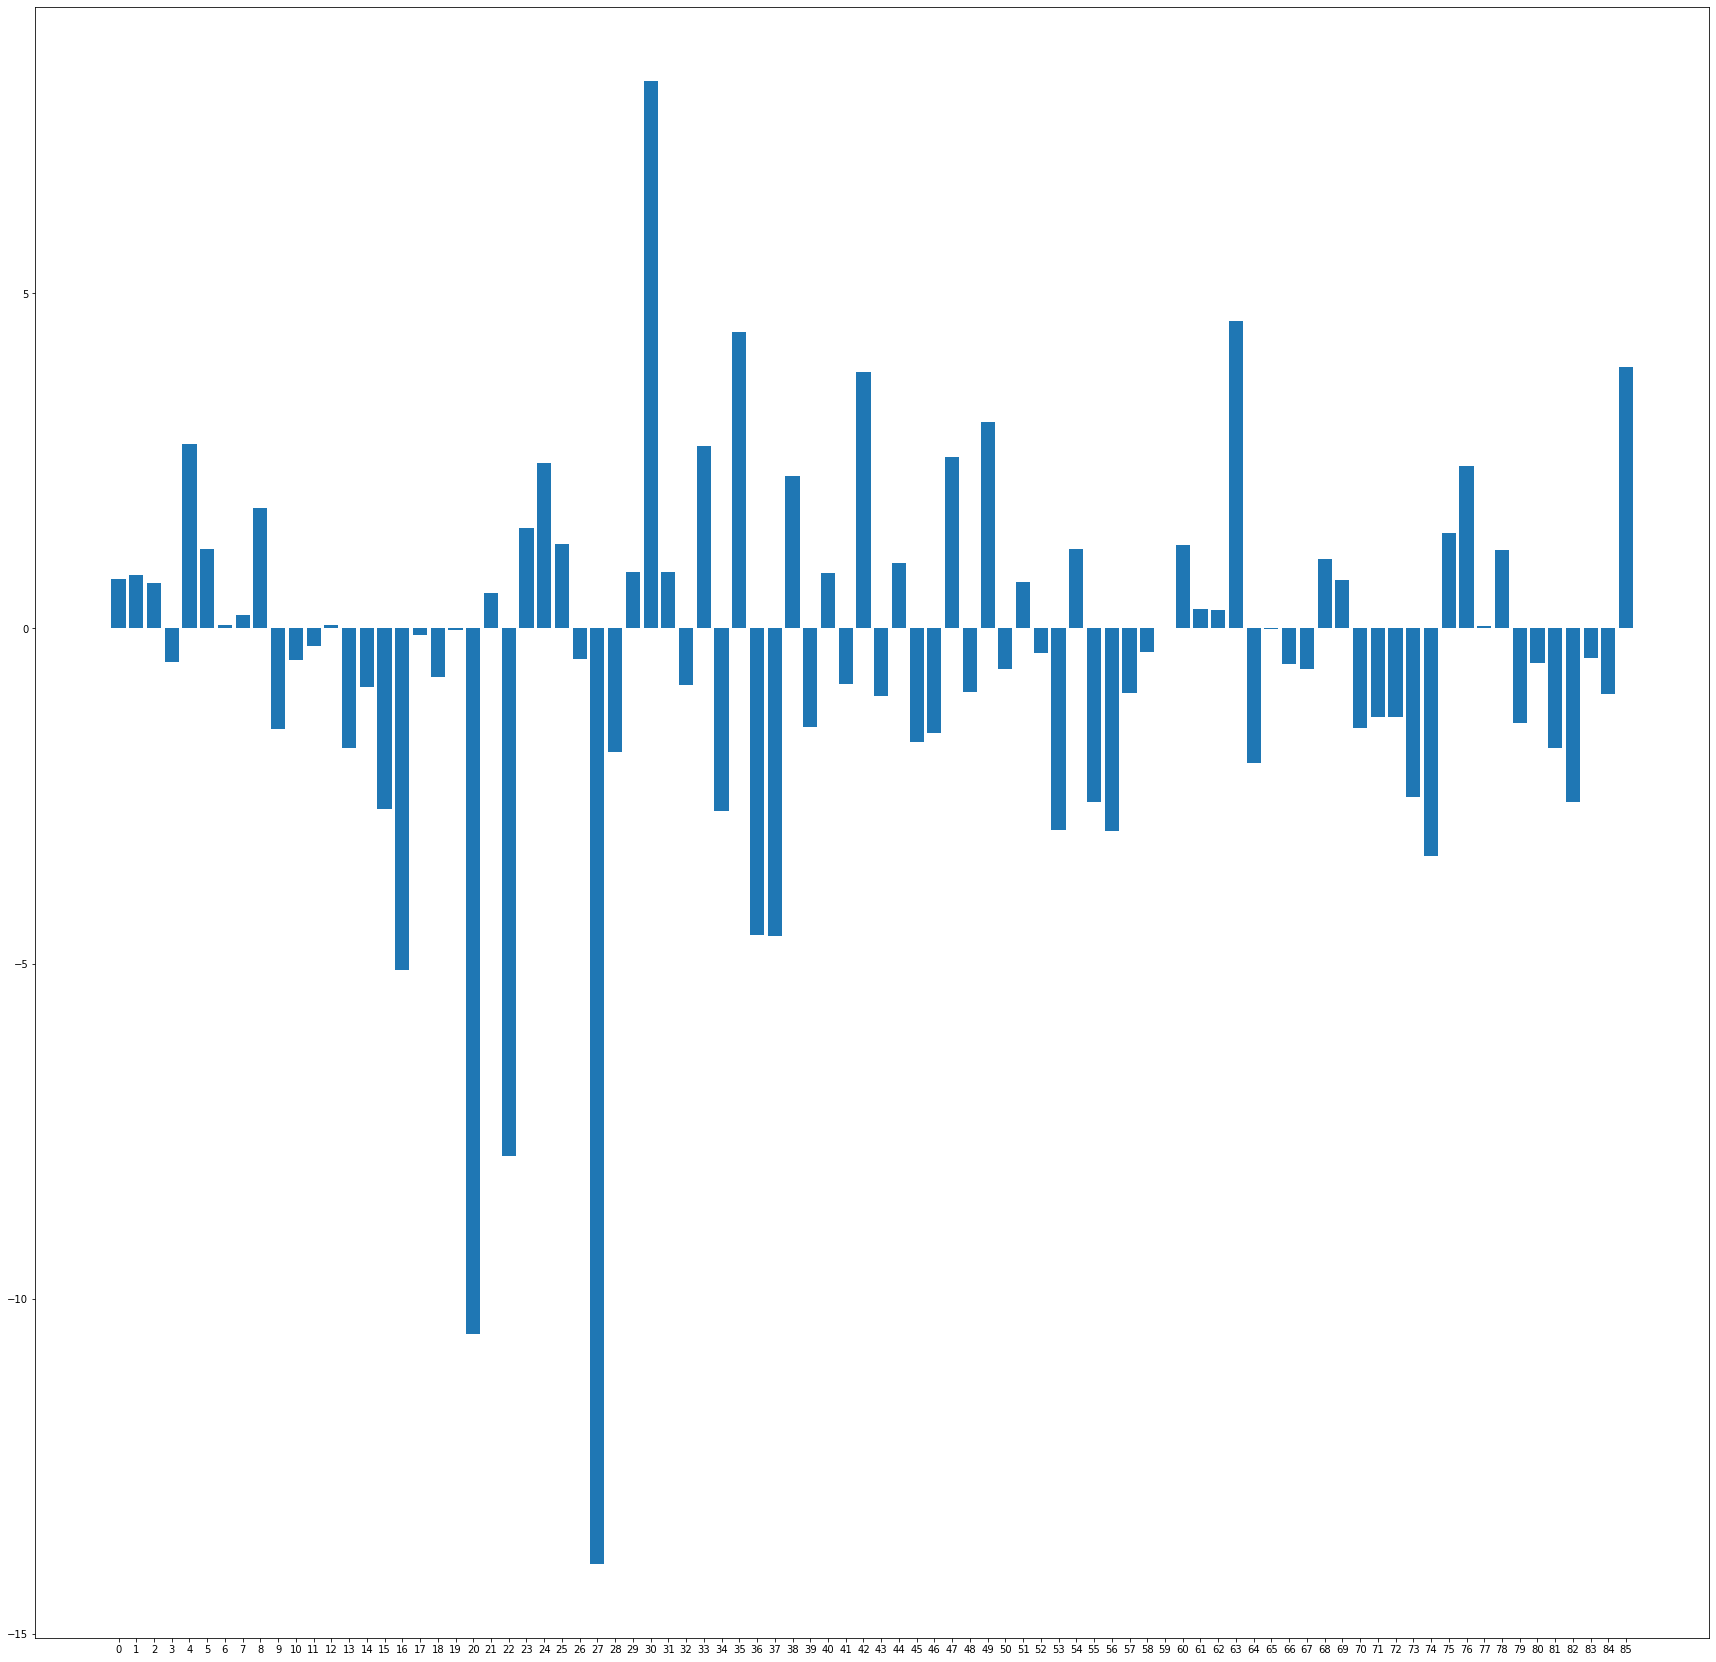

In [12]:
values = range(len(importance))

fig, ax = plt.subplots(figsize=(30,30))
plt.xticks(values)
plt.bar([x for x in range(len(importance))],importance)
plt.show()

In [13]:
# Significance

f_values, p_values = f_regression(X_train,y_train) 
for i,v in enumerate(p_values):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01163
Feature: 1, Score: 0.01231
Feature: 2, Score: 0.01102
Feature: 3, Score: 0.00406
Feature: 4, Score: 0.03507
Feature: 5, Score: 0.02468
Feature: 6, Score: 0.00887
Feature: 7, Score: 0.00413
Feature: 8, Score: 0.03201
Feature: 9, Score: 0.00220
Feature: 10, Score: 0.00377
Feature: 11, Score: 0.00145
Feature: 12, Score: 0.02850
Feature: 13, Score: 0.00675
Feature: 14, Score: 0.03159
Feature: 15, Score: 0.00066
Feature: 16, Score: 0.00281
Feature: 17, Score: 0.00600
Feature: 18, Score: 0.01140
Feature: 19, Score: 0.00649
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00228
Feature: 22, Score: 0.14143
Feature: 23, Score: 0.02167
Feature: 24, Score: 0.05294
Feature: 25, Score: 0.01561
Feature: 26, Score: 0.00480
Feature: 27, Score: 0.52037
Feature: 28, Score: 0.00001
Feature: 29, Score: 0.01282
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.17153
Feature: 34, Score: 0.17137
Feature: 35, Score: 0.00000
Fe

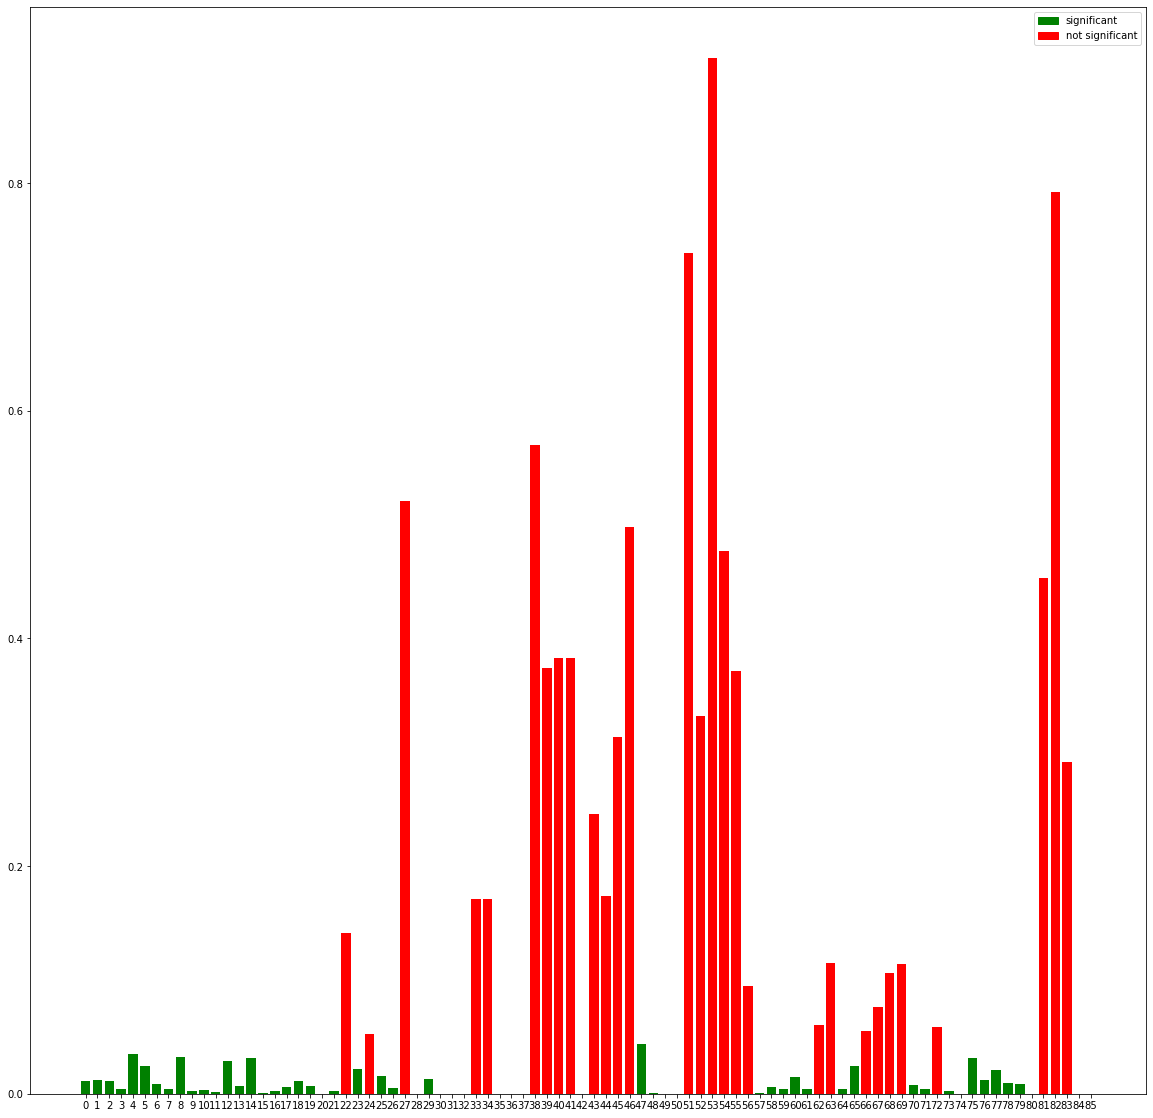

In [14]:
colours = [] 
for value in p_values:
    if value < 0.05:
        colours.append('g')
    else:
        colours.append ('r')

fig, ax = plt.subplots(figsize=(20,20))
plt.xticks(values)
plt.bar([x for x in range(len(p_values))],p_values, color = colours)
key = {'significant':'green', 'not significant':'red'}         
labels = list(key.keys())
handles = [plt.Rectangle((0,0),1,1, color=key[label]) for label in labels]
plt.legend(handles, labels)
plt.show()

# Classifier

## Preprocessing for classification

In [15]:
# Preprocessing for classification

df2['Permission (%) '] = np.where(df2['Permission (%) ']>70, 1, 0)
KNN = KNeighborsClassifier()
X, y = df2.iloc[:,:-1], df2.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 3)
df2.groupby('Permission (%) ').count()

# +- 40% split, good for classification models

,a_inw,a_man,a_vrouw,a_00_14,a_15_24,a_25_44,a_45_64,a_65_oo,a_ongeh,a_gehuwd,...,g_afs_hp,g_afs_gs,g_afs_kv,g_afs_sc,g_3km_sc,a_opp_ha,a_lan_ha,a_wat_ha,ste_mvs,ste_oad
Permission (%),,,,,,,,,,,,,,,,,,,,,
0,148,148,148,148,148,148,148,148,148,148,...,148,148,148,148,148,148,148,148,148,148
1,207,207,207,207,207,207,207,207,207,207,...,207,207,207,207,207,207,207,207,207,207


## Knn

The optimal  parameter = 3
The optimal amount of KNN gives 0.73 test accuracy


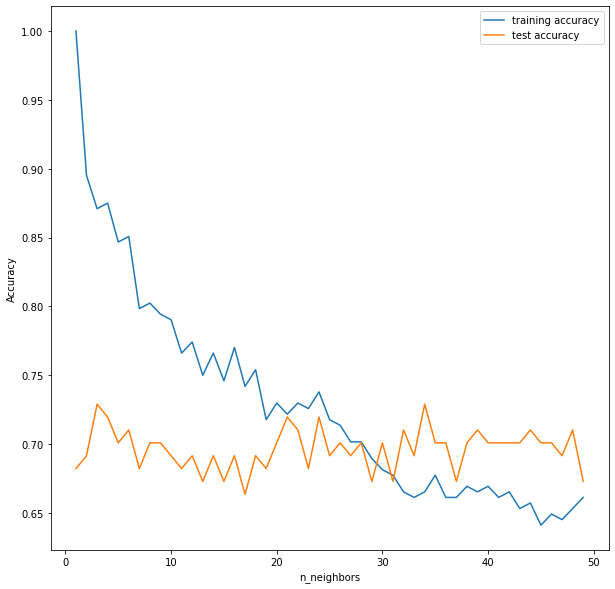

In [16]:
#KNN StandardScaler

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 49
neighbors_settings = range(1, 50)

for n_neighbors in neighbors_settings:
    # build the model
    clfpipe1 = Pipeline([('scaler', StandardScaler()), ('knn',KNeighborsClassifier(n_neighbors=n_neighbors))])
    clfpipe1.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clfpipe1.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clfpipe1.score(X_test, y_test))

print("The optimal  parameter = " + str(test_accuracy.index(max(test_accuracy)) + 1))
print(f"The optimal amount of KNN gives {max(test_accuracy).round(2)} test accuracy")
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [17]:
# StandardScaler Classification report

KnnStandard = Pipeline([('scaler', StandardScaler()), ('knn',KNeighborsClassifier(n_neighbors=3))])
KnnStandard.fit(X_train, y_train)
y_pred = KnnStandard.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.50      0.60        44
           1       0.72      0.89      0.79        63

    accuracy                           0.73       107
   macro avg       0.74      0.69      0.70       107
weighted avg       0.73      0.73      0.72       107



The optimal parameter = 4
The optimal amount of KNN gives 0.74 test accuracy


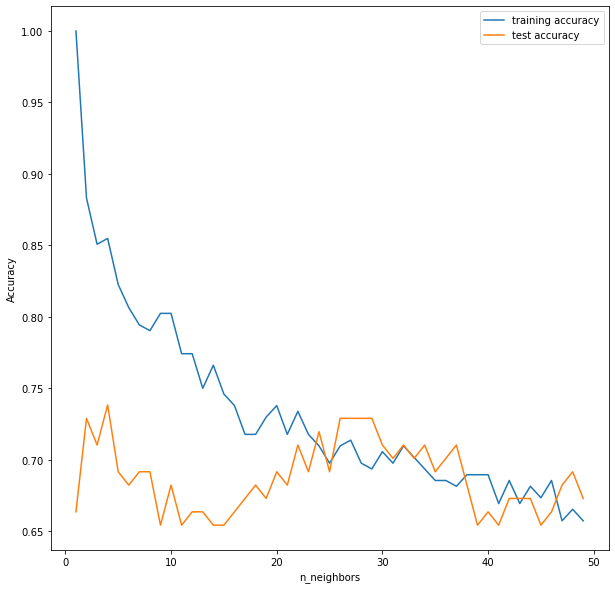

In [18]:
#KNN MinMaxScaler

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 49
neighbors_settings = range(1, 50)

for n_neighbors in neighbors_settings:
    # build the model
    clfpipe2 = Pipeline([('scaler', MinMaxScaler()), ('knn',KNeighborsClassifier(n_neighbors=n_neighbors))])
    clfpipe2.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clfpipe2.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clfpipe2.score(X_test, y_test))
  
print("The optimal parameter = " + str(test_accuracy.index(max(test_accuracy)) + 1))
print(f"The optimal amount of KNN gives {max(test_accuracy).round(2)} test accuracy")
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [19]:
#MinMaxScaler Classification report

KnnMinMax = Pipeline([('scaler', MinMaxScaler()), ('knn',KNeighborsClassifier(n_neighbors=4))])
KnnMinMax.fit(X_train, y_train)
y_pred = KnnMinMax.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.66      0.67        44
           1       0.77      0.79      0.78        63

    accuracy                           0.74       107
   macro avg       0.73      0.73      0.73       107
weighted avg       0.74      0.74      0.74       107



## Random forest

In [20]:
#Trying random Random Forest to check

forest = RandomForestClassifier(n_estimators = 5, random_state = 2)
forest.fit(X_train, y_train)
print(forest.score(X_test, y_test))
forest_pred = forest.predict(X_test)

0.7102803738317757


In [21]:
#Gridsearch on optimal parameters

forest_grid = RandomForestClassifier()
forest_estimators = {'n_estimators': (1,500,10), 'max_features': ["auto", "sqrt", "log2"], 'max_depth':  range(1,15,3)}
forest_estimators_grid = GridSearchCV(forest_grid, forest_estimators, cv=5)
forest_estimators_grid.fit(X_train, y_train)
print(f"Best parameters: {forest_estimators_grid.best_params_}")
print(f"Accuracy on train: {forest_estimators_grid.score(X_train, y_train)}")
print(f"Accuracy on test: {forest_estimators_grid.score(X_test, y_test)}")
print(classification_report(y_test, forest_pred))

Best parameters: {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 10}
Accuracy on train: 0.9919354838709677
Accuracy on test: 0.7476635514018691
              precision    recall  f1-score   support

           0       0.68      0.57      0.62        44
           1       0.73      0.81      0.77        63

    accuracy                           0.71       107
   macro avg       0.70      0.69      0.69       107
weighted avg       0.71      0.71      0.71       107



In [22]:
forest = RandomForestClassifier(max_depth = 10, max_features = 'auto', n_estimators = 10)
forest.fit(X_train, y_train)
importances_forest = forest.feature_importances_
for i,v in enumerate(importances_forest):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00639
Feature: 1, Score: 0.00443
Feature: 2, Score: 0.01265
Feature: 3, Score: 0.00209
Feature: 4, Score: 0.00941
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00471
Feature: 7, Score: 0.00237
Feature: 8, Score: 0.01430
Feature: 9, Score: 0.00440
Feature: 10, Score: 0.00673
Feature: 11, Score: 0.00330
Feature: 12, Score: 0.02756
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.03149
Feature: 15, Score: 0.00936
Feature: 16, Score: 0.00829
Feature: 17, Score: 0.00819
Feature: 18, Score: 0.00436
Feature: 19, Score: 0.01599
Feature: 20, Score: 0.03152
Feature: 21, Score: 0.00816
Feature: 22, Score: 0.01059
Feature: 23, Score: 0.02102
Feature: 24, Score: 0.02651
Feature: 25, Score: 0.02109
Feature: 26, Score: 0.00306
Feature: 27, Score: 0.01396
Feature: 28, Score: 0.01354
Feature: 29, Score: 0.00729
Feature: 30, Score: 0.04877
Feature: 31, Score: 0.01988
Feature: 32, Score: 0.00934
Feature: 33, Score: 0.00046
Feature: 34, Score: 0.01781
Feature: 35, Score: 0.01795
Fe

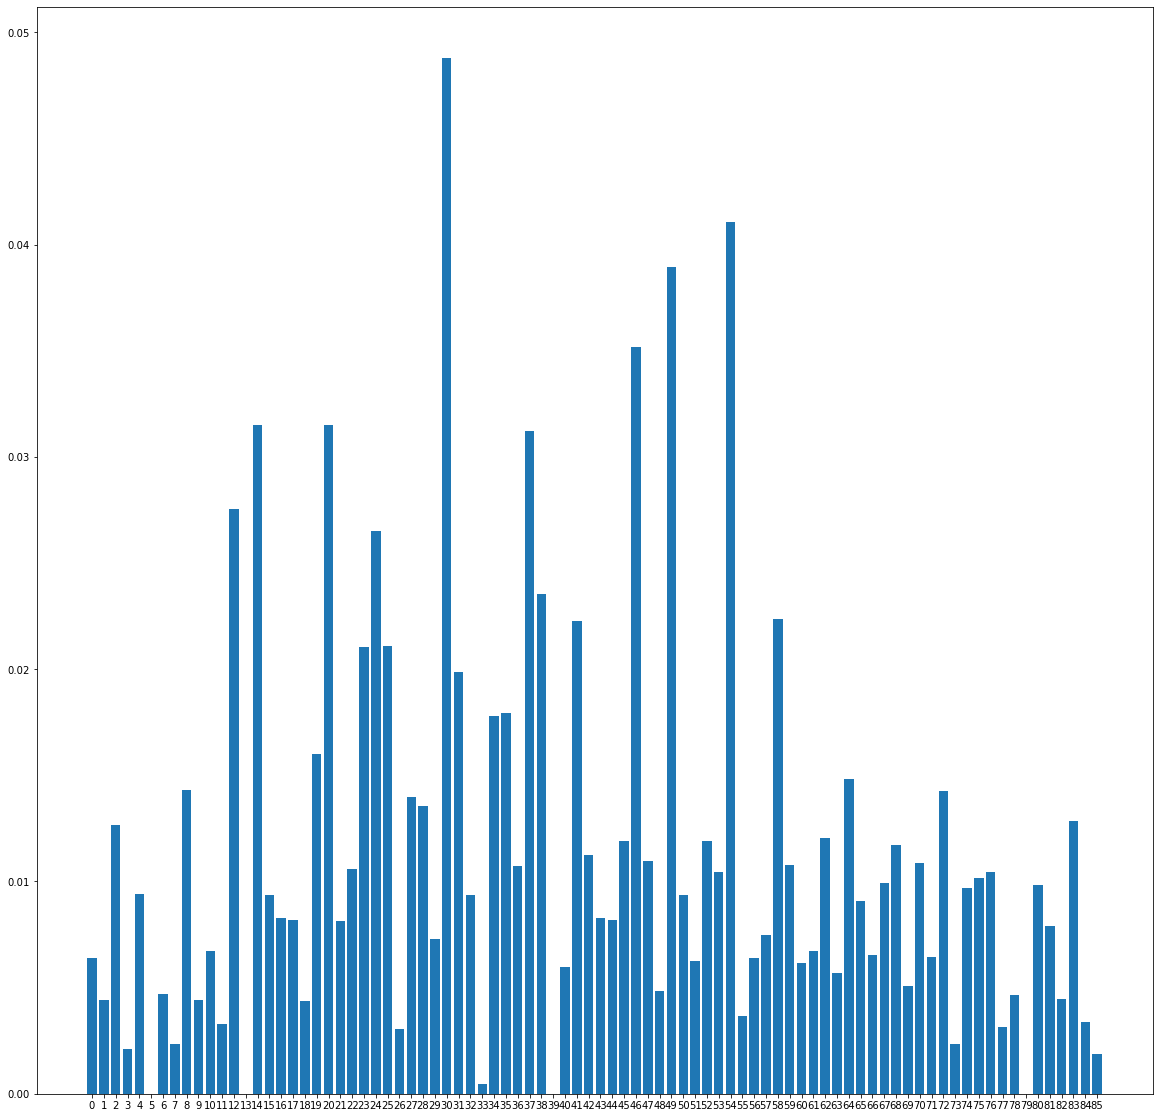

In [23]:
fig, ax = plt.subplots(figsize=(20,20))
plt.xticks(values)
plt.bar([x for x in range(len(importances_forest))], importances_forest)
plt.show()

In [24]:
#Classification report forest

optimalforest = RandomForestClassifier(max_depth = 10, max_features = 'auto', n_estimators = 500)
optimalforest.fit(X_train, y_train)
y_pred = optimalforest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.50      0.62        44
           1       0.72      0.92      0.81        63

    accuracy                           0.75       107
   macro avg       0.77      0.71      0.72       107
weighted avg       0.76      0.75      0.73       107



## Evaluating Knn vs Random Forest

AUC for Knn: 0.795
AUC for Random Forest: 0.766


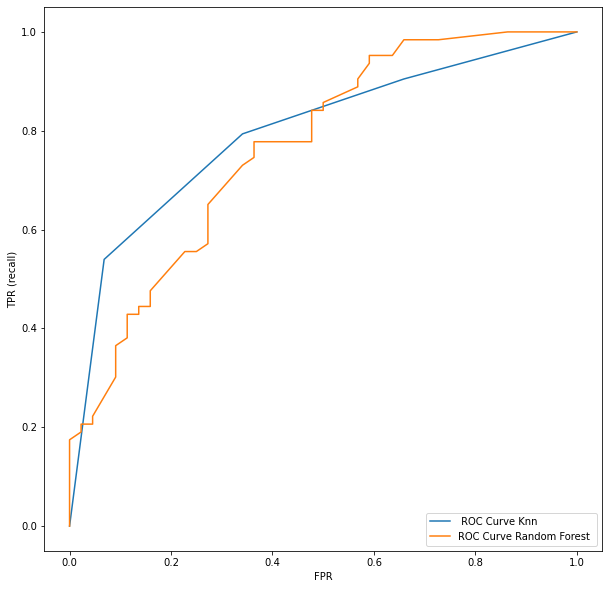

In [25]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, KnnMinMax.predict_proba(X_test)[:,1])
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, forest.predict_proba(X_test)[:, 1])
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(fpr_knn, tpr_knn, label=" ROC Curve Knn")
plt.plot(fpr_forest, tpr_forest, label="ROC Curve Random Forest ")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.legend(loc=4)

Knn_auc = roc_auc_score(y_test, KnnMinMax.predict_proba(X_test)[:,1])
forest_auc = roc_auc_score(y_test, forest.predict_proba(X_test)[:,1])
print("AUC for Knn: {:.3f}".format(Knn_auc))
print("AUC for Random Forest: {:.3f}".format(forest_auc))